<a href="https://colab.research.google.com/github/spencer18001/ml_zoomcamp_project_2024_midterm/blob/main/Notebook/notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%%capture
!pip install tqdm xgboost
!wget -O player_statistics_cleaned_final.csv https://raw.githubusercontent.com/spencer18001/ml_zoomcamp_project_2024_midterm/refs/heads/main/Data/player_statistics_cleaned_final.csv

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import OrdinalEncoder
from sklearn.feature_selection import mutual_info_regression
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mutual_info_score, root_mean_squared_error
from tqdm.auto import tqdm
import xgboost as xgb

## EDA

In [3]:
df_path = "player_statistics_cleaned_final.csv"
df = pd.read_csv(df_path)
df

,TeamName,PlayerName,Position,Games,Win rate,KDA,Avg kills,Avg deaths,Avg assists,CSPerMin,...,Avg VWPM,GD@15,CSD@15,XPD@15,FB %,FB Victim,Penta Kills,Solo Kills,Country,FlashKeybind
0,Top Esports,369,Top,8,0.500,3.1,2.5,2.4,4.9,7.6,...,0.13,322,5,424,0.000,0.250,0,2,China,D
1,Dplus KIA,aiming,Adc,9,0.333,4.8,5.0,2.0,4.7,10.1,...,0.10,-112,1,97,0.333,0.000,0,2,South Korea,F
2,MAD Lions KOI,alvaro,Support,5,0.200,1.5,0.2,4.4,6.2,1.2,...,0.49,-3,2,-256,0.000,0.600,0,-,Spain,D
3,Team Liquid,apa,Mid,10,0.500,2.4,3.5,3.2,4.2,8.7,...,0.18,278,2,216,0.400,0.000,0,3,United States,D
4,PSG Talon,azhi,Top,5,0.200,2.3,2.2,3.0,4.8,7.5,...,0.18,-311,-10,-168,0.200,0.000,0,-,Taiwan,D
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76,Team Liquid,yeon,Adc,10,0.500,4.9,3.8,1.8,5.0,10.0,...,0.16,224,6,571,0.500,0.000,0,-,United States,D
77,G2 Esports,yike,Jungle,8,0.375,4.5,3.1,2.4,7.6,6.4,...,0.22,102,4,-80,0.250,0.000,0,2,Sweden,D
78,Hanwha Life Esports,zeka,Mid,12,0.500,3.6,3.8,2.8,6.2,9.1,...,0.24,288,2,66,0.250,0.167,0,1,South Korea,F
79,T1,zeus,Top,8,0.875,7.1,3.9,1.6,7.6,7.9,...,0.19,633,8,370,0.125,0.000,0,2,South Korea,F


In [4]:
df.isnull().sum()

,0
TeamName,0
PlayerName,0
Position,0
Games,0
Win rate,0
KDA,0
Avg kills,0
Avg deaths,0
Avg assists,0
CSPerMin,0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 81 entries, 0 to 80
Data columns (total 27 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   TeamName       81 non-null     object 
 1   PlayerName     81 non-null     object 
 2   Position       81 non-null     object 
 3   Games          81 non-null     int64  
 4   Win rate       81 non-null     float64
 5   KDA            81 non-null     float64
 6   Avg kills      81 non-null     float64
 7   Avg deaths     81 non-null     float64
 8   Avg assists    81 non-null     float64
 9   CSPerMin       81 non-null     float64
 10  GoldPerMin     81 non-null     int64  
 11  KP%            81 non-null     float64
 12  DamagePercent  81 non-null     float64
 13  DPM            81 non-null     int64  
 14  VSPM           81 non-null     float64
 15  Avg WPM        81 non-null     float64
 16  Avg WCPM       81 non-null     float64
 17  Avg VWPM       81 non-null     float64
 18  GD@15       

In [6]:
for c in df.dtypes[df.dtypes == "object"].index:
    print(f"{df[c].value_counts().head(8)}\n")

TeamName
Bilibili Gaming    6
Top Esports        5
Dplus KIA          5
MAD Lions KOI      5
Team Liquid        5
PSG Talon          5
Weibo Gaming       5
G2 Esports         5
Name: count, dtype: int64

PlayerName
369          1
kingen       1
peyz         1
peanut       1
oscarinin    1
oner         1
on           1
noah         1
Name: count, dtype: int64

Position
Jungle     17
Top        16
Adc        16
Support    16
Mid        16
Name: count, dtype: int64

Solo Kills
-    38
1    18
2    16
3     6
4     1
6     1
5     1
Name: count, dtype: int64

Country
South Korea      30
China            19
Spain             6
Taiwan            5
Vietnam           5
United States     3
Brazil            3
Poland            2
Name: count, dtype: int64

FlashKeybind
D    44
F    37
Name: count, dtype: int64



In [7]:
df["Solo Kills"] = df["Solo Kills"].replace(to_replace="-", value=0)
df["Solo Kills"] = df["Solo Kills"].astype(int)
df["Solo Kills"].dtype

dtype('int64')

In [8]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Games,81.0,8.641975,2.908215,3.000,6.000,8.000,10.000,14.000
Win rate,81.0,0.455975,0.214833,0.000,0.333,0.500,0.615,0.875
KDA,81.0,3.765432,1.834677,1.200,2.400,3.400,4.400,9.300
Avg kills,81.0,2.686420,1.519355,0.200,1.200,2.500,3.900,5.600
Avg deaths,81.0,2.875309,0.896734,1.300,2.400,2.900,3.300,5.600
Avg assists,81.0,6.755556,2.390293,1.800,4.900,6.200,8.300,12.400
CSPerMin,81.0,6.656790,3.048850,1.000,5.700,7.900,8.900,10.500
GoldPerMin,81.0,362.654321,72.095797,225.000,320.000,385.000,416.000,486.000
KP%,81.0,0.680790,0.088962,0.410,0.623,0.691,0.751,0.849
DamagePercent,81.0,0.199605,0.084498,0.052,0.135,0.215,0.275,0.337


In [9]:
df.drop(columns=["Penta Kills"], inplace=True)

In [10]:
X = df.drop(columns=["Win rate"])
y = df["Win rate"]

encoder = OrdinalEncoder()
X_encoded = encoder.fit_transform(X)

mi = mutual_info_regression(X_encoded, y)

mi_lst = list(zip(X.columns, mi))
sorted_mi_lst = sorted(mi_lst, key=lambda x: x[1], reverse=True)
sorted_mi_lst

[('TeamName', 2.1418643149366776),
 ('Games', 1.5672304651308446),
 ('Country', 0.6505765163023134),
 ('KDA', 0.43699380142324973),
 ('FB %', 0.23733814380823715),
 ('GD@15', 0.2187175327594506),
 ('Avg deaths', 0.1930527654127836),
 ('Avg assists', 0.16403591849636356),
 ('XPD@15', 0.15417654939232195),
 ('FlashKeybind', 0.14091401553009275),
 ('CSD@15', 0.08295211066783326),
 ('FB Victim', 0.07524103846778774),
 ('DPM', 0.06644854936418021),
 ('Avg WPM', 0.0604501575048455),
 ('KP%', 0.0374090653744128),
 ('VSPM', 0.01565780273695294),
 ('PlayerName', 0.0),
 ('Position', 0.0),
 ('Avg kills', 0.0),
 ('CSPerMin', 0.0),
 ('GoldPerMin', 0.0),
 ('DamagePercent', 0.0),
 ('Avg WCPM', 0.0),
 ('Avg VWPM', 0.0),
 ('Solo Kills', 0.0)]

In [11]:
df.drop(columns=["TeamName", "PlayerName", "Country"], inplace=True)

In [12]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)

df_full_train = df_full_train.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_full_train = df_full_train["Win rate"].values
y_test = df_test["Win rate"].values

del df_full_train["Win rate"]
del df_test["Win rate"]

In [13]:
dv = DictVectorizer(sparse=False)

full_train_dict = df_full_train.to_dict(orient="records")
X_full_train = dv.fit_transform(full_train_dict)

test_dict = df_test.to_dict(orient="records")
X_test = dv.fit_transform(test_dict)

## Linear Regression

In [14]:
n_splits = 5
kfold = KFold(n_splits=n_splits, shuffle=True, random_state=1)

def train_kfold(train_func, **kwargs):
    rmse_list = []
    for train_idx, val_idx in kfold.split(df_full_train):
        X_train = X_full_train[train_idx]
        X_val = X_full_train[val_idx]

        y_train = y_full_train[train_idx]
        y_val = y_full_train[val_idx]

        y_pred = train_func(X_train, y_train, X_val, **kwargs)

        rmse = root_mean_squared_error(y_val, y_pred)
        rmse_list.append(rmse)
    return rmse_list

In [18]:
def train_linear(X_train, y_train, X_val, **kwargs):
    model = LinearRegression()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    return y_pred

In [16]:
def train_ridge(X_train, y_train, X_val, **kwargs):
    model = Ridge(**kwargs, random_state=1)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    return y_pred

In [112]:
def plot_rmse(df):
    plt.figure(figsize=(8, 5))

    print(df.index)
    plt.errorbar(df.index, df["rmse_mean"],
                yerr=2*df["rmse_std"], fmt='o',
                color='blue', ecolor='red', elinewidth=2, capsize=4, alpha=0.7)

    plt.xlabel("index")
    plt.ylabel("rmse_mean")
    plt.grid(True)
    plt.show()

In [115]:
scores = []
for alpha in tqdm([0, 0.01, 0.1, 0.5, 1, 10, 100]):
    if alpha == 0:
        rmse_list = train_kfold(train_func=train_linear)
    else:
        rmse_list = train_kfold(train_func=train_ridge, alpha=alpha)

    rmse_mean = np.mean(rmse_list)
    rmse_std = np.std(rmse_list)
    scores.append((alpha, rmse_mean, rmse_std))

  0%|          | 0/7 [00:00<?, ?it/s]

RangeIndex(start=0, stop=7, step=1)


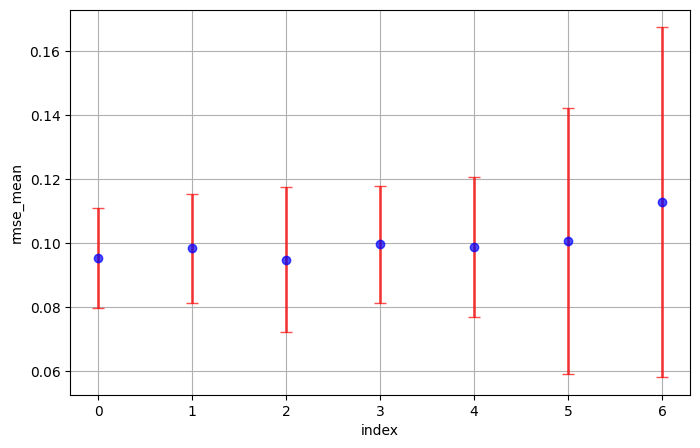

,alpha,rmse_mean,rmse_std,rmse_upper
0,0.10,0.095403,0.007754,0.110910
1,0.50,0.098392,0.008509,0.115411
2,0.01,0.094829,0.011305,0.117439
3,0.00,0.099709,0.009155,0.118020
4,1.00,0.098836,0.010923,0.120681
5,10.00,0.100718,0.020734,0.142185
6,100.00,0.112800,0.027335,0.167470


In [121]:
columns = ["alpha", "rmse_mean", "rmse_std"]
df_scores = pd.DataFrame(scores, columns=columns)
df_scores["rmse_upper"] = df_scores["rmse_mean"] + 2*df_scores["rmse_std"]
df_sorted_scores = df_scores.sort_values(by="rmse_upper").reset_index(drop=True)
df_sorted_scores_sub = df_sorted_scores.head(10).reset_index(drop=True)
plot_rmse(df_sorted_scores_sub)
df_sorted_scores_sub

## Decision Tree

In [151]:
def train_decision_tree(X_train, y_train, X_val, **kwargs):
    model = DecisionTreeRegressor(**kwargs, random_state=1)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    return y_pred

In [152]:
scores = []
for max_depth in tqdm([1, 2, 3, 4, 5, 6, 10, 15, 20, None]):
    for min_samples_leaf in [1, 5, 10, 15, 20, 50, 100, 200]:
        rmse_list = train_kfold(train_func=train_decision_tree, max_depth=max_depth, min_samples_leaf=min_samples_leaf)

        rmse_mean = np.mean(rmse_list)
        rmse_std = np.std(rmse_list)
        scores.append((max_depth, min_samples_leaf, rmse_mean, rmse_std))

  0%|          | 0/10 [00:00<?, ?it/s]

RangeIndex(start=0, stop=10, step=1)


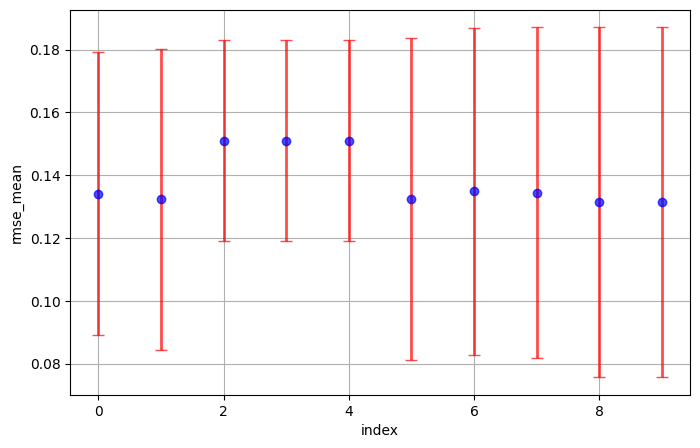

,max_depth,min_samples_leaf,rmse_mean,rmse_std,rmse_upper
0,5.0,1,0.134121,0.022483,0.179087
1,2.0,10,0.132412,0.023963,0.180338
2,1.0,1,0.151008,0.016004,0.183015
3,1.0,5,0.151008,0.016004,0.183015
4,1.0,10,0.151008,0.016004,0.183015
5,2.0,5,0.132428,0.025559,0.183547
6,6.0,1,0.134842,0.026005,0.186852
7,4.0,5,0.134388,0.026365,0.187117
8,4.0,10,0.131415,0.027859,0.187133
9,20.0,10,0.131415,0.027859,0.187133


In [168]:
columns = ["max_depth", "min_samples_leaf", "rmse_mean", "rmse_std"]
df_scores = pd.DataFrame(scores, columns=columns)
df_scores["rmse_upper"] = df_scores["rmse_mean"] + 2*df_scores["rmse_std"]
df_sorted_scores = df_scores.sort_values(by="rmse_upper").reset_index(drop=True)
df_sorted_scores_sub = df_sorted_scores.head(10).reset_index(drop=True)
plot_rmse(df_sorted_scores_sub)
df_sorted_scores_sub

## Random Forest

In [167]:
def train_random_forest(X_train, y_train, X_val, **kwargs):
    model = RandomForestRegressor(**kwargs, random_state=1, n_jobs=-1)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    return y_pred

In [171]:
scores = []
for n_estimators in tqdm([10, 30, 50, 100, 150, 200]):
    for max_depth, min_samples_leaf in df_sorted_scores_sub[["max_depth", "min_samples_leaf"]].values:
        max_depth = None if pd.isna(max_depth) else int(max_depth)
        min_samples_leaf = int(min_samples_leaf)

        rmse_list = train_kfold(train_func=train_random_forest, n_estimators=n_estimators,
                                max_depth=max_depth, min_samples_leaf=min_samples_leaf)

        rmse_mean = np.mean(rmse_list)
        rmse_std = np.std(rmse_list)
        scores.append((n_estimators, max_depth, min_samples_leaf, rmse_mean, rmse_std))

  0%|          | 0/6 [00:00<?, ?it/s]

RangeIndex(start=0, stop=10, step=1)


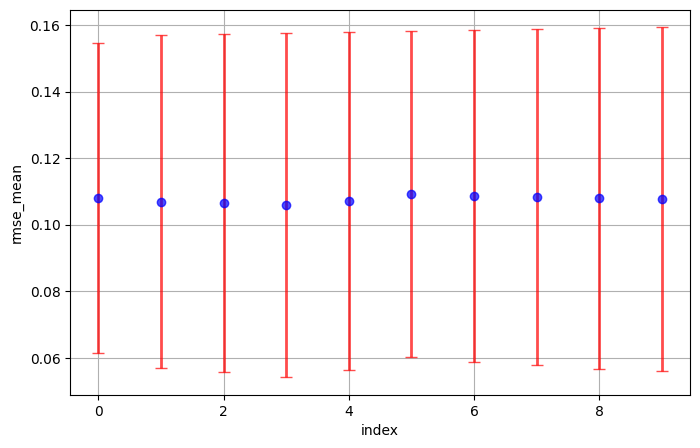

,n_estimators,max_depth,min_samples_leaf,rmse_mean,rmse_std,rmse_upper
0,10,5,1,0.108063,0.023272,0.154606
1,200,5,1,0.106890,0.025024,0.156939
2,30,6,1,0.106563,0.025352,0.157266
3,200,6,1,0.105877,0.025862,0.157601
4,30,5,1,0.106995,0.025373,0.157741
5,100,5,1,0.109197,0.024489,0.158175
6,100,6,1,0.108722,0.024934,0.158591
7,150,5,1,0.108365,0.025210,0.158785
8,150,6,1,0.107864,0.025555,0.158975
9,50,6,1,0.107721,0.025797,0.159315


In [172]:
columns = ["n_estimators", "max_depth", "min_samples_leaf", "rmse_mean", "rmse_std"]
df_scores = pd.DataFrame(scores, columns=columns)
df_scores["rmse_upper"] = df_scores["rmse_mean"] + 2*df_scores["rmse_std"]
df_sorted_scores = df_scores.sort_values(by="rmse_upper").reset_index(drop=True)
df_sorted_scores_sub = df_sorted_scores.head(10).reset_index(drop=True)
plot_rmse(df_sorted_scores_sub)
df_sorted_scores_sub

## XGBoost

In [ ]:
def train_xgboost(X_train, y_train, X_val, **kwargs):
    features = list(dv.get_feature_names_out())
    dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=features)
    dval = xgb.DMatrix(X_val, feature_names=features)

    model = xgb.train(xgb_params, dtrain, num_boost_round=10)
    y_pred = model.predict(dval)
    return y_pred